In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from sklearn.cross_validation import train_test_split


L=32
data=np.loadtxt("data/output_config.dat")
len_s=data.shape[0]
temperature=data[:,-1]
configurations=data[:,:-1]
configurations=(configurations+np.pi)/(2*np.pi)


Using TensorFlow backend.
/home/kris/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
batch_size = 20
original_dim = configurations.shape[1]
latent_dim = 2
intermediate_dim =256
nb_epoch = 50
epsilon_std = 1

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


def vae_loss(x, x_decoded_mean):
    x=x*2*np.pi
    x_decoded_mean=x_decoded_mean*2*np.pi
    xent_loss = objectives.mean_squared_error(K.cos(x), K.cos(x_decoded_mean))+objectives.mean_squared_error(K.sin(x), K.sin(x_decoded_mean))
#    xent_loss = original_dim * (objectives.cosine_proximity(K.cos(x), K.cos(x_decoded_mean)))
#    xent_loss =objectives.cosine_proximity(K.cos(x), K.cos(x_decoded_mean))+objectives.cosine_proximity(K.sin(x), K.sin(x_decoded_mean))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss/2 + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (20, 1024)            0                                            
____________________________________________________________________________________________________
dense_16 (Dense)                 (20, 256)             262400      input_5[0][0]                    
____________________________________________________________________________________________________
dense_17 (Dense)                 (20, 2)               514         dense_16[0][0]                   
____________________________________________________________________________________________________
dense_18 (Dense)                 (20, 2)               514         dense_16[0][0]                   
___________________________________________________________________________________________

In [4]:
x_train, x_test = train_test_split(configurations, train_size = 0.9)


vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
       validation_data=(x_test, x_test))

Train on 1800 samples, validate on 200 samples
Epoch 1/50
1800/1800 [==============================] - 1s - loss: 6.6884 - val_loss: 1.3939
Epoch 2/50
1800/1800 [==============================] - 1s - loss: 2.3320 - val_loss: 3.3416
Epoch 3/50
1800/1800 [==============================] - 1s - loss: 2.1079 - val_loss: 2.6430
Epoch 4/50
1800/1800 [==============================] - 1s - loss: 1.8793 - val_loss: 1.3599
Epoch 5/50
1800/1800 [==============================] - 1s - loss: 1.8299 - val_loss: 1.1514
Epoch 6/50
1800/1800 [==============================] - 1s - loss: 1.7513 - val_loss: 1.3763
Epoch 7/50
1800/1800 [==============================] - 1s - loss: 1.6569 - val_loss: 1.4101
Epoch 8/50
1800/1800 [==============================] - 1s - loss: 1.5796 - val_loss: 1.3581
Epoch 9/50
1800/1800 [==============================] - 1s - loss: 1.5101 - val_loss: 1.6260
Epoch 10/50
1800/1800 [==============================] - 1s - loss: 1.4988 - val_loss: 1.4240
Epoch 11/50
1800/1800 

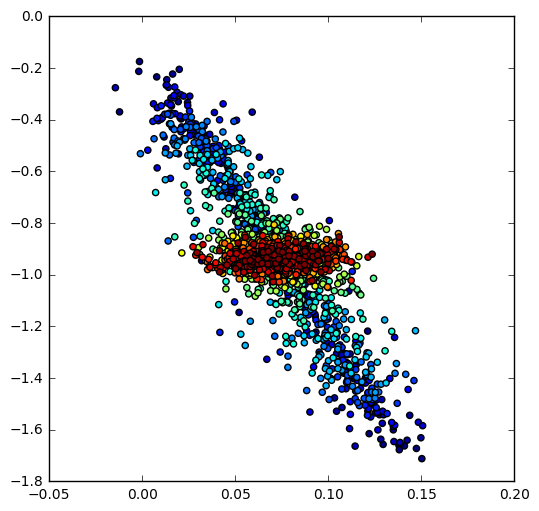

In [5]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_train_encoded = encoder.predict(configurations, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1],c=temperature)
#plt.colorbar()
plt.show()

In [19]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [25]:
def vortex_plot_decoded(z):
    config_decoded=generator.predict(z)
    config_x=np.cos(config_decoded)
    config_y=np.sin(config_decoded)
    x_new,y_new,xy=config_x.reshape((L,L)),config_y.reshape((L,L)),config_decoded.reshape((L,L))
    plt.figure(figsize=(6, 6))
    plt.quiver(X,Y,x_new,y_new,clim=[-3.15,3.15])
    plt.axis('equal')
    plt.axis('off')
#    plt.title('='.join(vortex_plot_decodedvortex_plot_decoded('T',str(round(temperature[tn],2)))))
#    cbar = plt.colorbar(ticks=[-3.14, 0, 3.14])
    #    cbar.ax.set_yticklabels([r"\pi", r"0", r"-\pi"])
    plt.show() 

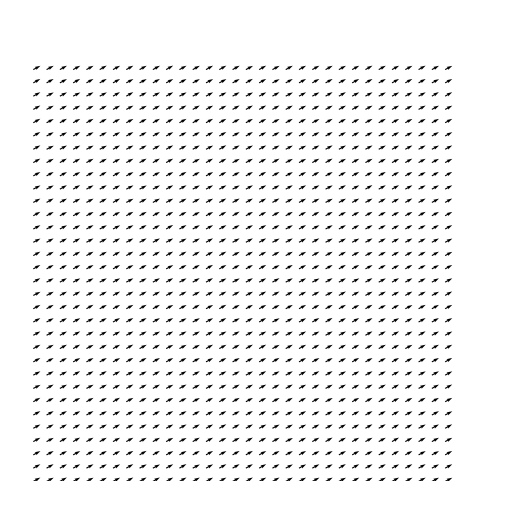

In [28]:
vortex_plot_decoded(np.array([[-1,0.5]]))

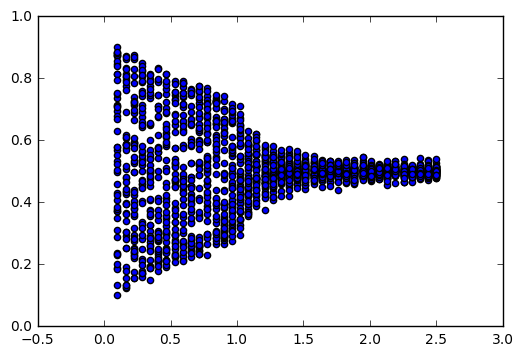

In [13]:
plt.scatter(temperature,configurations.mean(axis=1))
plt.show()

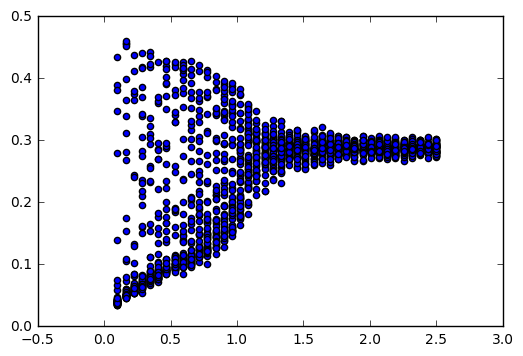

In [12]:
plt.scatter(temperature,configurations.std(axis=1))
plt.show()